In [1]:
import numpy as np
import matplotlib.pyplot as plt
import re
plt.rcParams["figure.figsize"] = (15,4)

# Benchmarks structure de données
## Conditions 

### Machine de test

https://groupes.renater.fr/wiki/poincare/public/description_de_poincare

### Benchmark

le benchmark ** bench_mesh ** est executé en faisant varier :
* nb_proc : nombre de processus MPI
* nb_threads : pour les executions avec 1 processus MPI, on utilise 1, 8, ou 16 coeurs, lorsqu'il y a plusieurs processus MPI, on se contente de 8 coeurs (1 socket)

Le benchmark mesure le temps d'execution de 4 parcours. ** bench_mesh ** crée un ficher avec pour nom out_p<nb_proc>_r<rang>_t<nb_threads>_s<size> :

In [2]:
!cat data/out_p1_r0_t1_s1e+05

#Clock percision is 1ns
#Density is 5e+14 m/m^3, segment length is 50.03 A
#size = 100000 (1.0e+05) , ITER = 100
#omp_max_threads = 1
#Times in ns for fastest iteration
    Compute (MFlops):         1.2         2.4         4.8         9.6        19.2        38.4        76.8       153.6       307.2       614.4
 load/store (MBytes):         7.2         7.2         7.2         7.2         7.2         7.2         7.2         7.2         7.2         7.2
              Stream:        502.1        519.0        634.7        993.9       2947.9       5932.8      12387.5      36400.9      73354.1     149979.5
               Nodes:        455.2        503.8        573.7       2336.4       3875.1       7470.1      15292.8      33742.5      70305.6     149757.1
     Segs with Nodes:       1422.5       1450.0       1501.6       1736.7       3519.1       6676.2      13875.5      32483.4      70456.8     149673.2
     Nodes with Segs:       3566.2       3634.9       3988.7       4594.4       5921.2     

## Extraire les données

In [3]:
!grep -r ':' data/out_* > data/filtered_data.txt

res_matrix={}
flops_count={}
loadstore_size={}

for line in open("data/filtered_data.txt"):
    nb_proc,rank,threads,size,name,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10 = re.match(".*out_p(\d*)_r(\d*)_t(\d*)_s(\d*e\+\d*):\s*([^:]*):\s*(\d*.\d*)\s*(\d*.\d*)\s*(\d*.\d*)\s*(\d*.\d*)\s*(\d*.\d*)\s*(\d*.\d*)\s*(\d*.\d*)\s*(\d*.\d*)\s*(\d*.\d*)\s*(\d*.\d*)", line).groups()
    ts = np.array([t1,t2,t3,t4,t5,t6,t7,t8,t9,t10],dtype='f')
    rank=int(rank)
    nb_proc=int(nb_proc)
    threads=int(threads)
    if name == 'Compute (MFlops)' :
        flops_count[size,nb_proc] = ts
    elif name == 'load/store (MBytes)' :
        loadstore_size[size,nb_proc] = ts
    else :
        res_matrix[nb_proc,rank,threads,size,name] = ts

list_nb_procs = sorted([a for a in set([ p for (p,r,t,s,n) in  res_matrix.keys() ])])
list_threads = sorted([a for a in set([ t for (p,r,t,s,n) in  res_matrix.keys() ])])
list_sizes = sorted([a for a in set([ s for (p,r,t,s,n) in  res_matrix.keys() ])])
list_names = [a for a in set([ n for (p,r,t,s,n) in  res_matrix.keys() ])]

print(res_matrix)

## Benchmarks OpenMP

### Mesures Roofline

Les bandes passantes RAM sont mesurées avec le benchmark STREAM (triad) sur 1, 8, et 16 coeurs
* 1 coeur : 14.0Go/s
* 1 noeud NUMA (8 coeurs): 29.9Go/s
* 1 noeud complet (16 coeurs) : 59,5Go/s

Les puissance de calcul crète (GFlops/s) est la puissance théorique du processeur :
* 2.6 GHz \* 2 ALU * 4 double/opération = 20.8 GFlops/s/coeur
* 5.2 GFlops/s/coeur sans vectorisation

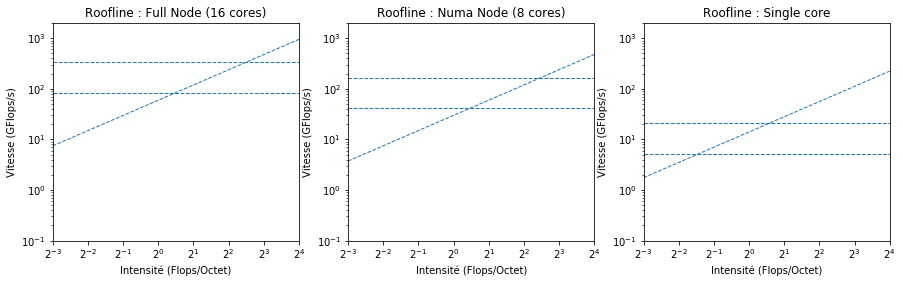

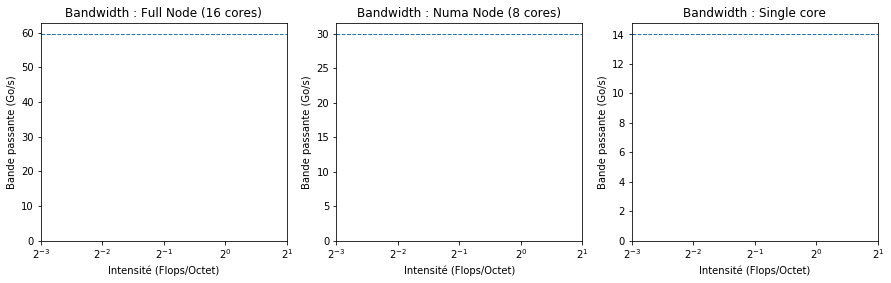

In [11]:
titles_threads = { 16:"Full Node (16 cores)", 8:"Numa Node (8 cores)", 1:"Single core" }
bandwidth = { 16:59.5, 8:29.9, 1:14.0 }
peak = { 16:332.8, 8:166.4, 1:20.8 }


def plot_roofline(threads):
    line = plt.axhline(y=peak[threads], linestyle='dashed', linewidth=1)
    Is = np.array([1./8,16])
    plt.axhline(y=peak[threads]/4, linestyle='dashed', linewidth=1, color=line.get_color())
    plt.plot( Is, Is*bandwidth[threads], linestyle='dashed', linewidth=1, color=line.get_color() )
    plt.xlabel( "Intensité (Flops/Octet)" )
    plt.ylabel( "Vitesse (GFlops/s)" )
    plt.xscale('log',basex=2)
    plt.yscale('log')
    plt.ylim([0.1,2000])
    plt.xlim(Is)

i=1
for threads in titles_threads.keys():
    plt.subplot(1, 3, i).title.set_text("Roofline : " + titles_threads[threads])
    plot_roofline(threads)
    i=i+1

plt.show()

def plot_bandwidth(threads):
    plt.axhline(y=bandwidth[threads], linestyle='dashed', linewidth=1)
    plt.xlabel( "Intensité (Flops/Octet)" )
    plt.ylabel( "Bande passante (Go/s)" )
    plt.xscale('log',basex=2)
    #plt.yscale('log')
    plt.ylim(0)
    Is = np.array([1./8,2])
    plt.xlim(Is)
i=1
for threads in titles_threads.keys():
    plt.subplot(1, 3, i).title.set_text("Bandwidth : " + titles_threads[threads])
    plot_bandwidth(threads)
    i=i+1

plt.show()


### Mesures structure de données

#### Roofline

Le roofline model donne un apercu de l'efficacité du parcours des stuctures de données en affichant la performance maximale atteignable et en placant la performance mesurée sur un graphique.

Les performances sont calculées sur la base des Flops utiles executées lors d'un parcours.

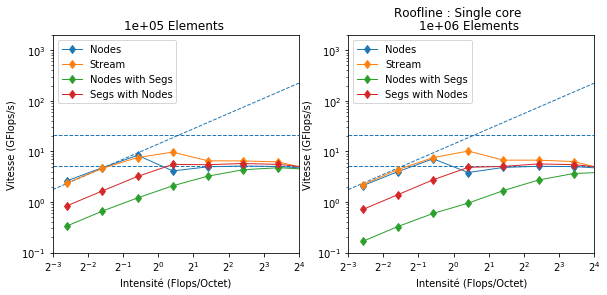

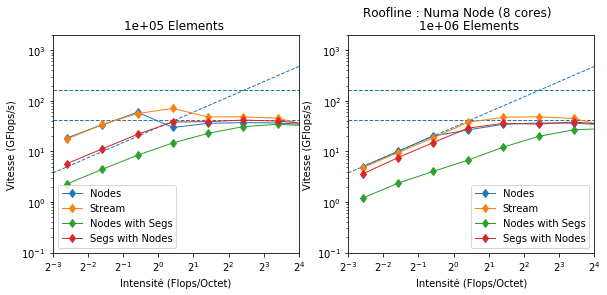

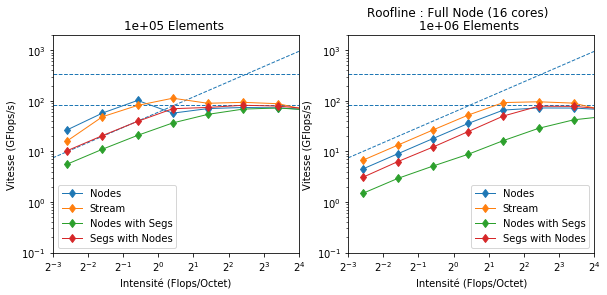

In [12]:
nb_proc=1
rank=0

list_sizes = ['1e+05', '1e+06']

for threads in list_threads:
    i=1
    plt.suptitle("Roofline : " + titles_threads[threads])
    for size in list_sizes:        
        plt.subplot(1, 3, i).title.set_text(size+" Elements ")
        plot_roofline(threads)
        for name in list_names:
            intensities = flops_count[size,nb_proc]/loadstore_size[size,nb_proc]
            Gflopss = (flops_count[size,nb_proc]/res_matrix[nb_proc,rank,threads,size,name])*1000
            plt.plot( intensities, Gflopss, 'd-', label=name, linewidth=1 )
        plt.legend()        
        i=i+1
    plt.show()

Les différents algorithmes :
 * Les performances de stream et Nodes sont très similaires : il n'y a pas d'accès irréguliers dans Nodes.
 * 'Segs with nodes' et 'nodes with segs' ont des performances moins bonnes à cause des accès irréguliers.
 * 'nodes with segs' en derniers : on ne sais pas combien de segments sont connectés a l'avance
 
Dans la partie memory-bound : 
* effets de cache à 1e5
* Moins bonne performance avec la structure en numa
* plus détails par la suite

Dans la partie compute-bound :
* Seul stream dépasse vraiment la perf max sans vecto

#### Bande passante

Les graphiques de bande passante permettent de mieux voir les valeurs mesurées dans la partie memory-bound du roofline model

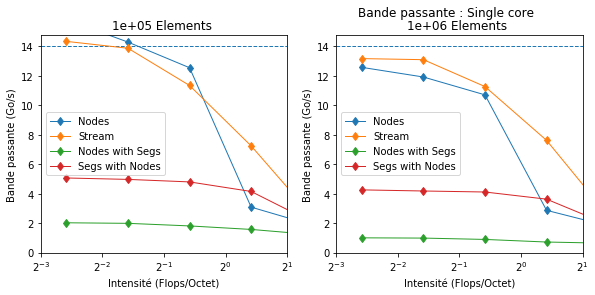

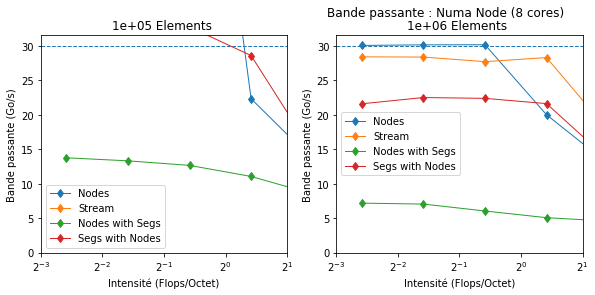

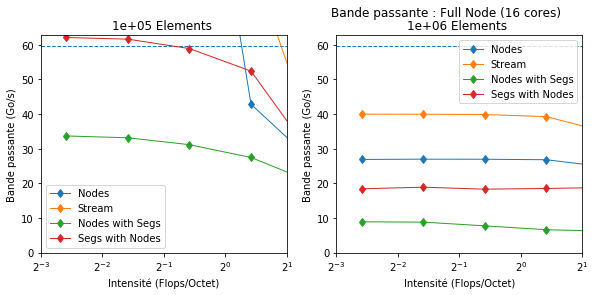

In [17]:
nb_proc=1
rank=0

list_sizes = ['1e+05', '1e+06']

for threads in list_threads:
    i=1
    plt.suptitle("Bande passante : " + titles_threads[threads])
    for size in list_sizes:        
        plt.subplot(1, 3, i).title.set_text(size+" Elements ")
        plot_bandwidth(threads)
        for name in list_names:
            intensities = flops_count[size,nb_proc]/loadstore_size[size,nb_proc]
            GBps = (loadstore_size[size,nb_proc]/res_matrix[nb_proc,rank,threads,size,name])*1000
            plt.plot( intensities, GBps, 'd-', label=name, linewidth=1 )
        plt.legend()        
        i=i+1
    plt.show()

## Benchmarks MPI

In [18]:
threads=8
intensity=2
list_sizes_mpi = ['1e+05', '1e+06']

intensity_val = flops_count['1e+05',1][intensity]/loadstore_size['1e+05',1][intensity]

nb_procs = np.array(list_nb_procs)

times_max={}
times_min={}
for size in list_sizes_mpi:        
    for name in list_names:
        times_max[size,name] = [ max([ res_matrix[p,rank,threads,size,name][intensity] for rank in range(p) ]) for p in nb_procs ]
        times_min[size,name] = [ min([ res_matrix[p,rank,threads,size,name][intensity] for rank in range(p) ]) for p in nb_procs ]
        

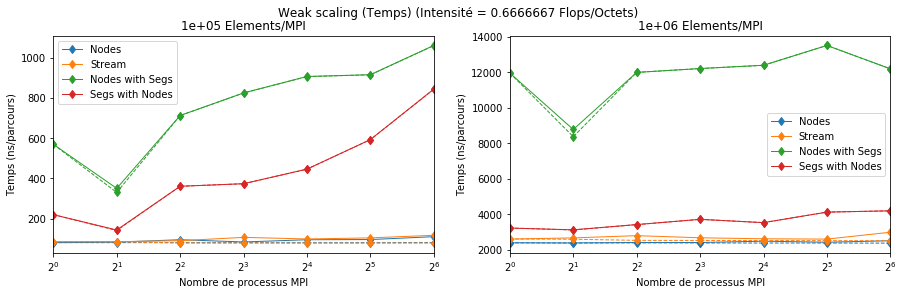

In [19]:
i=1
fig,ax=plt.subplots()
plt.suptitle("Weak scaling (Temps) (Intensité = "+str(intensity_val)+" Flops/Octets)")
for size in list_sizes_mpi:        
    plt.subplot(1, 2, i).title.set_text(size+" Elements/MPI")
    for name in list_names:
        nb_procs = np.array(list_nb_procs)
        line, = plt.plot( nb_procs, times_max[size,name],'d-', label=name, linewidth=1 )
        plt.plot( nb_procs, times_min[size,name],'d--', linewidth=1, color=line.get_color())
        plt.xscale('log',basex=2)
        ax.set_xticks(nb_procs)
        plt.xlim([1,64])
        plt.ylabel("Temps (ns/parcours)")
        plt.xlabel("Nombre de processus MPI")
    plt.legend()        
    i=i+1
plt.show()

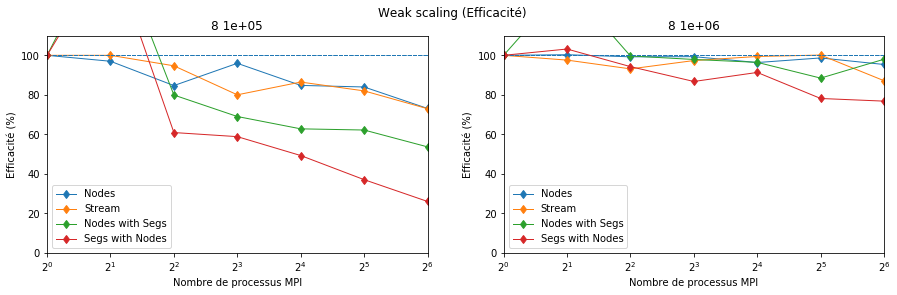

In [20]:
rank=0
i=1
plt.suptitle("Weak scaling (Efficacité)" )
for size in list_sizes_mpi:        
    plt.subplot(1, 2, i).title.set_text(size+" Elements/MPI")
    for name in list_names:
        plt.axhline(y=100, linestyle='dashed', linewidth=1)
        plt.plot( nb_procs, times_max[size,name][0]/times_max[size,name]*100, 'd-', label=name, linewidth=1 )
        plt.xscale('log',basex=2)
        plt.xlim([1,64])
        plt.ylim([0,110])
        plt.ylabel("Efficacité (%)")
        plt.xlabel("Nombre de processus MPI")
        #plt.ylim([0,110])
    plt.legend()        
    plt.title(str(threads)+" "+size)
    i=i+1
plt.show()